In [755]:
# Import libraries and set desired options
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import sparse, stats
from scipy.linalg import svd
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier

In [802]:
TRAIN_PATH = 'train/'
X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')

Y = pd.read_csv(TRAIN_PATH + 'Y.csv')

TEST_PATH = 'test/'
X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')

In [803]:
user_ids, counts = np.unique(X2['id'], return_counts=True)
user_ids_test, counts_test = np.unique(X2_test['id'], return_counts=True)

In [804]:
urlcounter = pd.DataFrame(np.stack((user_ids, counts),axis=-1), columns=['id', 'counts'])
df_train = X1.merge(urlcounter,on='id')

In [805]:
urlcounter_test = pd.DataFrame(np.stack((user_ids_test, counts_test),axis=-1), columns=['id', 'counts'])
df_test = X1_test.merge(urlcounter_test,on='id')

Посмотрим на сайты которые посещают в тесте и сайты которые посещают в трэйне

Text(0.5, 1.0, 'Distributions of number of visits, bins=100')

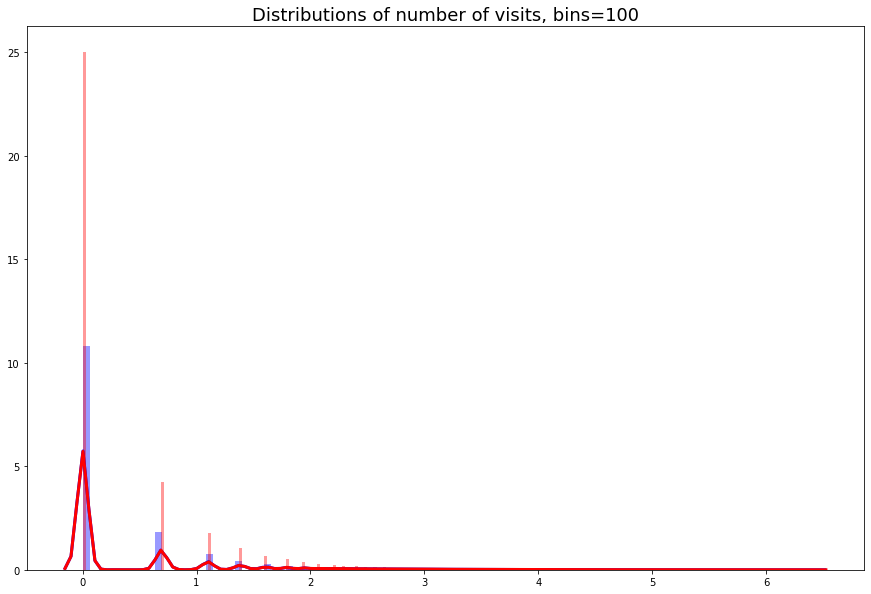

In [806]:
site_ids, counts_ = np.unique(X2['A'], return_counts=True)
site_ids_test, counts_test_ = np.unique(X2_test['A'], return_counts=True)
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.distplot(np.log(counts_), bins=100, ax=ax, color='blue', kde_kws={'linewidth':3})
ax = sns.distplot(np.log(counts_test_), bins=len(np.unique(counts_test_)), ax=ax, color='red', kde_kws={'linewidth':3})
ax.set_title('Distributions of number of visits, bins=100', fontsize=18)

In [807]:
A = set(np.unique(X2['A']))

B = set(np.unique(X2_test['A']))


len(A.intersection(B))
# inter = np.array(list(A.intersection(B)))
inter = np.array(list(A.union(B)))
len(inter)

214075

Text(0.5, 1.0, 'Distributions of number of visits, bins=100')

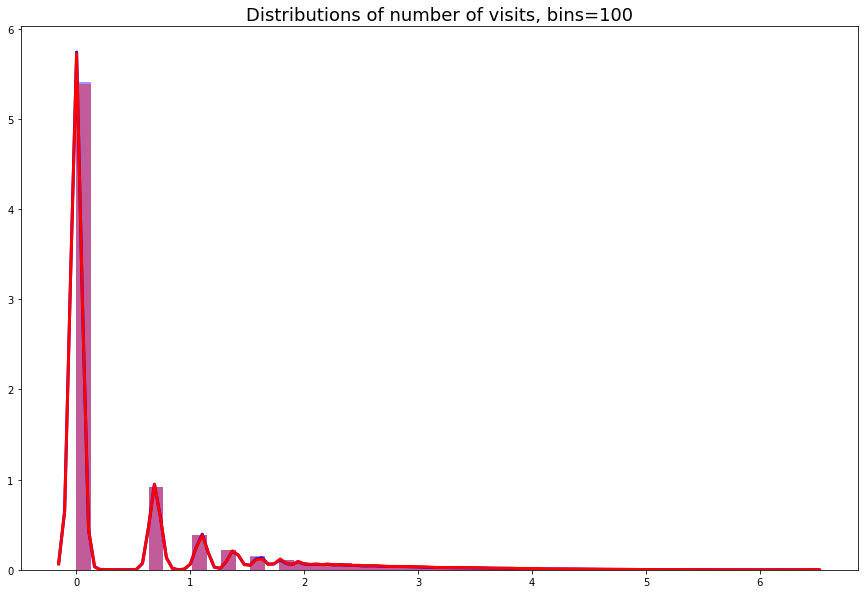

In [808]:
site_ids, counts_ = np.unique(X2['A'], return_counts=True)
site_ids_test, counts_test_ = np.unique(X2_test['A'], return_counts=True)
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.distplot(np.log(counts_[mm]), bins=50, ax=ax, color='blue', kde_kws={'linewidth':3})
ax = sns.distplot(np.log(counts_test_[mm_test]), bins=50, ax=ax, color='red', kde_kws={'linewidth':3})
ax.set_title('Distributions of number of visits, bins=100', fontsize=18)

Посчитаем количество сайтов определенного уровня популярности, которые посещает пользователь

In [809]:
mm = np.isin(np.unique(X2['A']), inter)

In [810]:
mm_test = np.isin(np.unique(X2_test['A']), inter)

In [811]:
site_ids, counts_ = np.unique(X2['A'], return_counts=True)
site_ids_test, counts_test_ = np.unique(X2_test['A'], return_counts=True)
bounds = [0,10,50,100,200,300,400,500, float('inf')]

In [812]:
res = pd.DataFrame(np.unique(X2.id), columns=['id'])
for i in range(1, len(bounds)):
    _ = site_ids[(bounds[i-1] <= counts_) & (counts_ < bounds[i]) & mm]
    mask = X2['A'].isin(_)
    kek = X2.loc[mask].groupby('id').count()
    res = res.merge(kek, right_index=True, left_on='id',how='left').fillna(0)
    res = res.rename(columns={'A':bounds[i]})
res.iloc[:,-5:] = res.iloc[:,-5:].div(res.iloc[:,-5:].sum(1), axis=0)
df_train = df_train.merge(res, on='id', how='left')

In [813]:
res = pd.DataFrame(np.unique(X2_test.id), columns=['id'])
for i in range(1, len(bounds)):
    _ = site_ids_test[(bounds[i-1] <= counts_test_) & (counts_test_ < bounds[i]) & mm_test]
    mask = X2_test['A'].isin(_)
    kek = X2_test.loc[mask].groupby('id').count()
    res = res.merge(kek, right_index=True, left_on='id',how='left').fillna(0)
    res = res.rename(columns={'A':bounds[i]})
res.iloc[:,-5:] = res.iloc[:,-5:].div(res.iloc[:,-5:].sum(1), axis=0)
df_test = df_test.merge(res, on='id', how='left')

In [814]:
def cross_validation_score_statement(estimator,
                                     params,
                                     X,
                                     y,
                                     scoring=roc_auc_score,
                                     n_splits=8,
                                     statement=None,
                                     random_state=[0,42,5,16]):
    """
    Evaluate a score by cross-validation. 
    The fit method will be performed on the entire train subset at each iteration,
    the predict method and scoring will be performed only for objects from test subset where statement is True
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit' and 'predict'
        The object to use to fit the data.
    X : pandas.DataFrame
        The data to fit.
    y : pandas.Series
        The target variable to try to predict.
    scoring : callable 
        The scoring function of signature scoring(y_true,y_pred).
    statement : boolean numpy.array of shape equal to y.shape
        The mask showing the objects we want to evaluate estimator on.
    n_splits : int
        Number of folds for cross-validation
    random_state : int
        Random_state for KFold and StratifiedKFold    
    
    Returns
    -----------
    scores : array of float, shape=(n_splits,)
    
    """
    
    scores = []
    train_scores = []
    models = []
    
    for seed in random_state:
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)#False??
        cv_iter = list(cv.split(X, y))

        for train, test in cv_iter:
    #         for num in params:
            cls = estimator(**params)
    #             print(X.iloc[train, :].values)
            cls.fit(X.iloc[train, :].values, y.iloc[train].values)
            y_statement = y.iloc[test]
            pred_statement = cls.predict_proba(X.iloc[test, :].values)[:, 1]
            scores.append(scoring(y_statement, pred_statement))
            train_scores.append(scoring(y.iloc[train], cls.predict_proba(X.iloc[train, :].values)[:, 1]))
            models += [cls]
    return np.array(scores), np.array(train_scores), models

In [815]:
df_train.shape

(4000, 35)

In [816]:
df_test.shape

(4058, 35)

In [817]:
model = LGBMClassifier('rf')

In [818]:
params = {i: {'boosting_type':'rf','learning_rate':0.005, 'n_estimators':200,\
                         'colsample_bytree':0.4, 'num_leaves':31, 'subsample':0.4, 'subsample_freq':1,\
                         'reg_alpha':0.01, 'min_child_samples':1, 'min_child_weight':1e-5,\
              'categorical_feature':'12'} for i in range(5)}

In [819]:
model = LGBMClassifier(**params[0])

In [820]:
cols = ['5','7', '4', '6', '8','9']
df_train[[i+'log' for i in cols]] = np.log(df_train[cols]+1)
df_test[[i+'log' for i in cols]] = np.log(df_test[cols]+1)
df_train['randn'] = np.random.rand(len(df_train))
df_test['randn'] = np.random.rand(len(df_test))
df_train[[i+'log_rev' for i in cols]] = (np.log(df_train[cols]+1)+1)**-1
df_test[[i+'log_rev' for i in cols]] = (np.log(df_test[cols]+1)+1)**-1
df_train[[i+'rev' for i in cols]] = (df_train[cols]+1)**-1
df_test[[i+'rev' for i in cols]] = (df_test[cols]+1)**-1

In [821]:
from category_encoders import JamesSteinEncoder,CatBoostEncoder

In [56]:
cat = []
for i in df_train.columns:
    if len(np.unique(df_train[i])) <= 10:
        cat += [i]

In [57]:
enc = JamesSteinEncoder(cols=cat, sigma=0.05)

In [58]:
_ = enc.fit_transform(df_train, Y.iloc[:,1])

In [59]:
__test = enc.transform(df_test)

In [60]:
df_train.columns == df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [61]:
params = {'boosting_type':'rf','learning_rate':0.0001, 'n_estimators':2000, 'objective':'binary',\
                         'colsample_bytree':0.4, 'num_leaves':31, 'subsample':0.1, 'subsample_freq':1,\
                         'reg_alpha':0, 'reg_lambda':0, 'min_child_samples':50, 'min_child_weight':0.00005}

In [62]:
res1, res2, models = cross_validation_score_statement(LGBMClassifier,params, _.iloc[:,1:], Y.iloc[:,1])

In [63]:
res1, res2, np.mean(res1)

(array([0.58068286, 0.6085755 , 0.58320955, 0.58755701, 0.63399926]),
 array([0.62574675, 0.61913595, 0.6246818 , 0.62385609, 0.61532551]),
 0.5988048364769003)

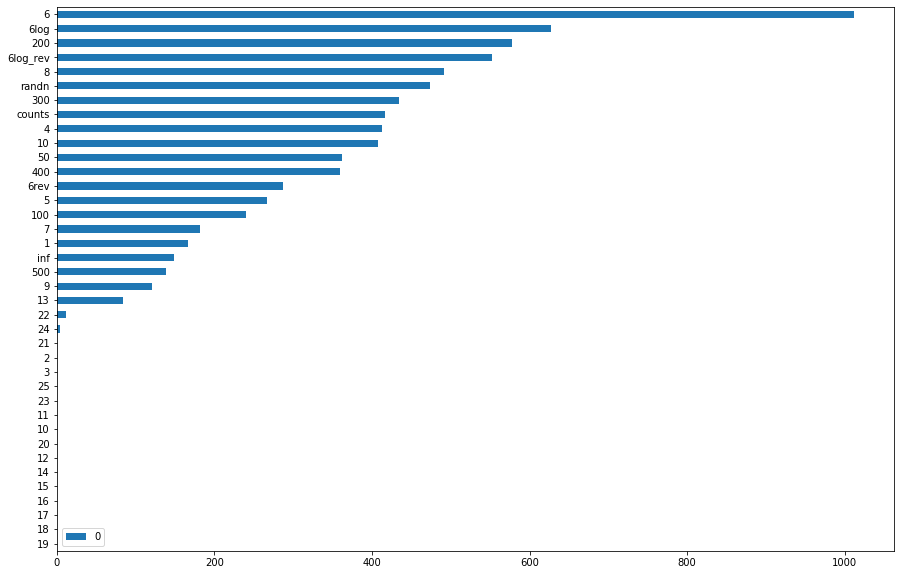

In [64]:
__ = pd.DataFrame(models[0].feature_importances_, index = _.columns[1:]).sort_values(0)
__.plot(kind='barh', figsize=(15,10))

In [65]:
_ = df_train.drop(columns=['3','11','2','10','16','12','14','15','17','18','19','20','21','23','25'])

In [66]:
res1, res2, models = cross_validation_score_statement(LGBMClassifier,params, _.iloc[:,1:], Y.iloc[:,1])
res1, res2, np.mean(res1)

(array([0.58119796, 0.60974359, 0.58276157, 0.58760094, 0.63392832]),
 array([0.62562824, 0.61988946, 0.62553367, 0.62417175, 0.61491736]),
 0.5990464767241835)

In [67]:
params = {'boosting_type':'rf','learning_rate':0.0001, 'n_estimators':2000,\
                         'colsample_bytree':0.4, 'num_leaves':40, 'subsample':0.1, 'subsample_freq':1,\
                         'reg_alpha':0, 'reg_lambda':0, 'min_child_samples':40, 'min_child_weight':0.5}

In [68]:
res1, res2, models = cross_validation_score_statement(LGBMClassifier,params, _.iloc[:,1:], Y.iloc[:,1])
res1, res2, np.mean(res1)

(array([0.57912217, 0.61066239, 0.58409764, 0.59006816, 0.63426176]),
 array([0.63132362, 0.62567101, 0.63171789, 0.63062767, 0.62238937]),
 0.5996424246094904)

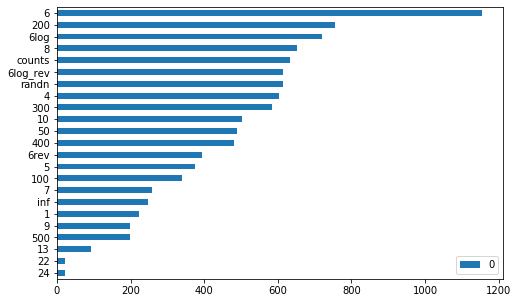

In [69]:
__ = pd.DataFrame(models[0].feature_importances_, index = _.columns[1:]).sort_values(0)
__.plot(kind='barh', figsize=(8,5))

In [70]:
def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    #sparse_matrix = np.zeros((len(rows), len(cols)))
    sparse_matrix = sparse.csc_matrix(([1]*len(row_pos), (row_pos, col_pos)), (len(rows), len(cols)))

    #sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

#    minimum_users_per_group = 5
    minimum_users_per_group = 0
    selected_cols = np.arange(cols_.shape[-1])[np.array(cols_ >= minimum_users_per_group).ravel()]
    trimmed_sparse_matrix = sparse_matrix[:, selected_cols]

    sns.distplot(trimmed_sparse_matrix.sum(axis=0), bins=100)

    if svd is None:
        #svd = TruncatedSVD(n_components=150)
        svd = TruncatedSVD(n_components=1)
        svd.fit(trimmed_sparse_matrix)

    components = pd.DataFrame(svd.transform(trimmed_sparse_matrix))
    components['id'] = X2.iloc[:, 0].unique()
    X2 = components
    return X2, svd

### X2 factorization experiment

In [71]:
from sklearn.decomposition import NMF

In [72]:
rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
#sparse_matrix = np.zeros((len(rows), len(cols)))
sparse_matrix = sparse.csc_matrix(([1]*len(row_pos), (row_pos, col_pos)), (len(rows), len(cols)))

**NMF**

In [166]:
nmf = NMF(20, max_iter=100)
nmfres = pd.DataFrame(nmf.fit_transform(sparse_matrix))
nmfres.rename(columns = {i:'nmf'+str(i) for i in nmfres.columns}, inplace = True)
nmfres['id'] = X2.loc[:,'id'].unique()
_ = df_train.merge(nmfres, on='id')

**SVD**

In [167]:
svd = TruncatedSVD(n_components=20, n_iter=100)
nmfres = svd.fit_transform(sparse_matrix)
nmfres = pd.DataFrame(nmfres/svd.singular_values_[np.newaxis,:])
nmfres.rename(columns = {i:'svd'+str(i) for i in nmfres.columns}, inplace = True)
nmfres['id'] = X2.loc[:,'id'].unique()
_ = _.merge(nmfres, on='id')

In [173]:
_ = _.drop(columns=['3','11','2','10','16','12','14','15','17','18','19','20','21','23','25'])

In [234]:
params = {'boosting_type':'rf','learning_rate':0.0001, 'n_estimators':2000, 'objective':'binary',\
                         'colsample_bytree':0.1, 'num_leaves':50, 'subsample':0.1, 'subsample_freq':1,\
                         'reg_alpha':0.1, 'reg_lambda':0, 'min_child_samples':50, 'min_child_weight':0.00005}

In [235]:
res1, res2, models = cross_validation_score_statement(LGBMClassifier,params, _.iloc[:,1:], Y.iloc[:,5])

In [236]:
res1, res2, np.mean(res1)

(array([0.59538918, 0.63018901, 0.62814945, 0.61447917, 0.62074985,
        0.58740647, 0.68518519, 0.59948826, 0.63514372, 0.61938103,
        0.61777582, 0.59207131, 0.62534099, 0.63775735, 0.62066439,
        0.5982218 , 0.61158681, 0.61526726, 0.62628675, 0.60180914,
        0.6406937 , 0.60105263, 0.61843878, 0.64023803, 0.62653329,
        0.65824505, 0.63115809, 0.57831935, 0.59342014, 0.63408786,
        0.59534984, 0.65322917]),
 array([0.67167933, 0.66822692, 0.66389471, 0.6729436 , 0.66681402,
        0.67396614, 0.66280031, 0.66679171, 0.66889385, 0.66653759,
        0.67092545, 0.66972966, 0.66727346, 0.66578986, 0.66688766,
        0.66826859, 0.66986878, 0.67033185, 0.66640714, 0.67298952,
        0.66727536, 0.66660034, 0.66881141, 0.6678862 , 0.66474441,
        0.66276438, 0.66611787, 0.67432349, 0.6720292 , 0.66632925,
        0.67118162, 0.66863677]),
 0.6197846519900879)

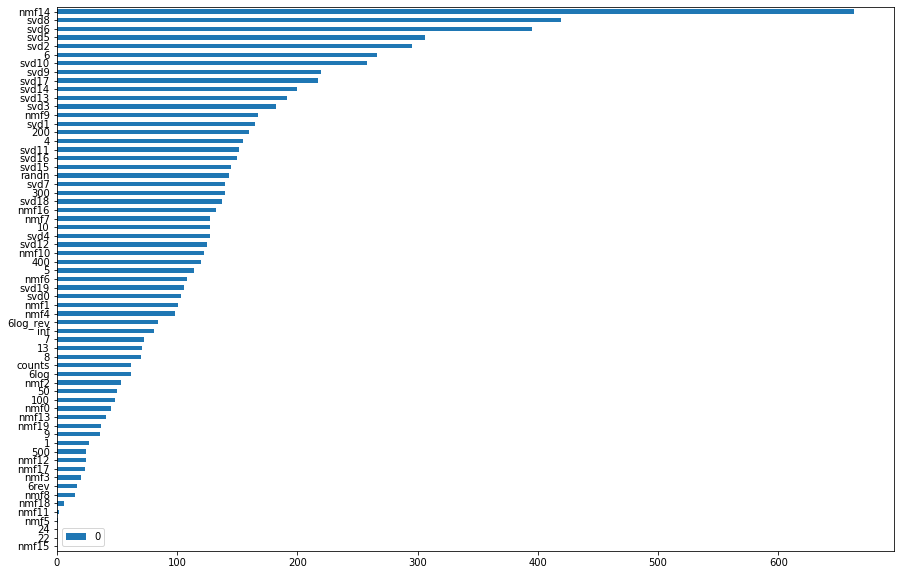

In [177]:
__ = pd.DataFrame(models[0].feature_importances_, index = _.columns[1:]).sort_values(0)
__.plot(kind='barh', figsize=(15,10))

## Final preprocessor

In [917]:
def preprocessor(X1, X2, mm, bounds = [0,10,50,100,200,300,400,500, float('inf')]):
    user_ids, counts = np.unique(X2['id'], return_counts=True)
    urlcounter = pd.DataFrame(np.stack((user_ids, counts),axis=-1), columns=['id', 'counts'])
    df_train = X1.merge(urlcounter,on='id')
    
    site_ids, counts_ = np.unique(X2['A'], return_counts=True)
    res = pd.DataFrame(np.unique(X2.id), columns=['id'])
    for i in range(1, len(bounds)):
        _ = site_ids[(bounds[i-1] <= counts_) & (counts_ < bounds[i]) & mm]
        mask = X2['A'].isin(_)
        kek = X2.loc[mask].groupby('id').count()
        res = res.merge(kek, right_index=True, left_on='id',how='left').fillna(0)
        res = res.rename(columns={'A':bounds[i]})
    res.iloc[:,-5:] = res.iloc[:,-5:].div(res.iloc[:,-5:].sum(1), axis=0)
    df_train = df_train.merge(res, on='id', how='left')
    
    cols = ['5','7', '4', '6', '8','9']
    df_train[[i+'log' for i in cols]] = np.log(df_train[cols]+1)
    df_train[[i+'log_rev' for i in cols]] = (np.log(df_train[cols]+1)+1)**-1
    df_train[[i+'rev' for i in cols]] = (df_train[cols]+1)**-1
    
    #df_train = df_train.drop(columns=['3','11','2','10','16','12','14','15','17','18','19','20','21','23','25'])
    return df_train

In [918]:
# X2_should be total
def svds(X2,df,inter):
    mask = np.isin(X2['A'], inter)
    rows, row_pos = np.unique(X2.iloc[mask, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[mask, 1], return_inverse=True)
    sparse_matrix = sparse.csc_matrix(([1]*len(row_pos), (row_pos, col_pos)), (len(rows), len(cols)))
    
    nmf = NMF(5, max_iter=300)
    nmfres = pd.DataFrame(nmf.fit_transform(sparse_matrix))
    nmfres.rename(columns = {i:'nmf'+str(i) for i in nmfres.columns}, inplace = True)
    nmfres['id'] = X2.loc[mask,'id'].unique()
    df = df.merge(nmfres, on='id', how='left').fillna(0)
    
    svd = TruncatedSVD(n_components=5, n_iter=300)
    nmfres = svd.fit_transform(sparse_matrix)
    nmfres = pd.DataFrame(nmfres/(svd.singular_values_[np.newaxis,:]+1e-5))
    nmfres.rename(columns = {i:'svd'+str(i) for i in nmfres.columns}, inplace = True)
    nmfres['id'] = X2.loc[mask,'id'].unique()
    df = df.merge(nmfres, on='id', how='left').fillna(0)
    
    return df

In [919]:
A = set(np.unique(X2['A']))
B = set(np.unique(X2_test['A']))
inter = np.array(list(A.union(B)))
mm = np.isin(np.unique(X2['A']), inter)
mm_test = np.isin(np.unique(X2_test['A']), inter)

df_train = preprocessor(X1, X2, mm)
df_test = preprocessor(X1_test, X2_test, mm_test)
df = df_train.append(df_test).fillna(0)

In [870]:
df = svds(X2.append(X2_test), df, inter)

In [920]:
mask = np.isin(df['id'],df_train['id'])
df_train = df[mask]
mask = np.isin(df['id'], df_test['id'])
df_test = df[mask]

In [921]:
params = {'boosting_type':'rf','learning_rate':0.0001, 'n_estimators':500, 'objective':'binary',\
                         'colsample_bytree':0.8, 'num_leaves':50, 'subsample':0.1, 'subsample_freq':1,\
                         'reg_alpha':0.1, 'reg_lambda':0, 'min_child_samples':50, 'min_child_weight':0.00005}

In [922]:
res1, res2, models = cross_validation_score_statement(LGBMClassifier,params, df_train.iloc[:,1:], Y.iloc[:,1])

In [681]:
__ = pd.DataFrame(models[0].feature_importances_, index = df_train.columns[1:]).sort_values(0)

In [723]:
_ = df_train.drop(columns = list(__.sort_values(0).index[:215]))

In [725]:
res1, res2, models = cross_validation_score_statement(LGBMClassifier,params, _.iloc[:,1:], Y.iloc[:,1])

In [726]:
res1, res2, np.mean(res1)

(array([0.5736862 , 0.60788032, 0.57891373, 0.58345567, 0.57743279,
        0.56768883, 0.64062166, 0.60811052, 0.56035754, 0.56830885,
        0.6       , 0.566495  , 0.65036588, 0.57348227, 0.62371391,
        0.5888757 , 0.60115607, 0.55424964, 0.5588    , 0.60023409,
        0.57739907, 0.59932826, 0.62057211, 0.61549831, 0.61372604,
        0.6028872 , 0.59784762, 0.58901172, 0.57053108, 0.57632685,
        0.58331361, 0.59818607]),
 array([0.62182811, 0.62069002, 0.62316533, 0.6206248 , 0.62331859,
        0.62235335, 0.6174651 , 0.61919781, 0.62483109, 0.62249326,
        0.6190885 , 0.62520438, 0.61404378, 0.62240991, 0.61662894,
        0.62281473, 0.6198265 , 0.6247129 , 0.6238436 , 0.61921183,
        0.62239331, 0.61969251, 0.61820412, 0.61641091, 0.61954763,
        0.61888365, 0.62104038, 0.62118137, 0.6252851 , 0.62149936,
        0.62218887, 0.619242  ]),
 0.5915142693611557)

In [842]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import VotingClassifier

### VotingRegresoor

In [893]:
params = {'boosting_type':'rf','learning_rate':0.0001, 'n_estimators':500, 'objective':'binary',\
                         'colsample_bytree':0.8, 'num_leaves':50, 'subsample':0.1, 'subsample_freq':1,\
                         'reg_alpha':0.1, 'reg_lambda':0, 'min_child_samples':50, 'min_child_weight':0.00005}

In [894]:
params_ = {'solver':'lbfgs', 'max_iter':500, 'n_jobs':-1, 'C':1e5, 'intercept_scaling':0.1}

In [907]:
p = {'estimators':[('1',LGBMClassifier(**params)),\
('2',LogisticRegression(**params_))], 'weights':[0.5,0.5], 'n_jobs':-1, 'voting':'soft'}

In [908]:
model = LGBMClassifier(**params)
scorer = lambda model, X, y: roc_auc_score(y, model.predict_proba(X)[:, 1])
selector = RFECV(model, 1, cv=5, scoring=scorer, n_jobs=12)
_ = selector.fit(df_train.iloc[:,1:], Y.iloc[:,5])
_ = list(df_train.iloc[:,1:].columns[selector.support_])

In [909]:
np.max(selector.grid_scores_)

0.5707693552286424

In [910]:
res1, res2, models = cross_validation_score_statement(VotingClassifier, p, df_train.loc[:,_], Y.iloc[:,5])

In [911]:
res1, res2, np.mean(res1)

(array([0.56638049, 0.57330989, 0.54417582, 0.57673611, 0.58786281,
        0.58042875, 0.58029952, 0.56684394, 0.58014586, 0.55831679,
        0.53172747, 0.59137521, 0.60841424, 0.54569853, 0.59479029,
        0.54478816, 0.58528352, 0.52370932, 0.57143374, 0.56504749,
        0.59725033, 0.55219015, 0.58779732, 0.61043272, 0.57760425,
        0.60979637, 0.57279412, 0.53320619, 0.55986111, 0.53527607,
        0.56231681, 0.63017361]),
 array([0.60070592, 0.59797527, 0.60433022, 0.59884228, 0.59722291,
        0.60260771, 0.59944041, 0.59859107, 0.6008652 , 0.59965324,
        0.60548887, 0.59666506, 0.59899997, 0.60432997, 0.59717183,
        0.59799666, 0.60621866, 0.60690514, 0.6009816 , 0.60307589,
        0.5905565 , 0.60450443, 0.60265468, 0.59416329, 0.60259124,
        0.59540088, 0.60386447, 0.60321488, 0.59835928, 0.60417135,
        0.60574936, 0.59367088]),
 0.5720458434504532)

In [845]:
model = LGBMClassifier(**params)
scorer = lambda model, X, y: roc_auc_score(y, model.predict_proba(X)[:, 1])
selector = RFECV(model, 1, cv=5, scoring=scorer, n_jobs=12)

df_train = df_train.fillna(0)
df_train = df_train.drop(columns = 'randn')

In [846]:
_ = selector.fit(df_train.iloc[:,1:], Y.iloc[:,1])
list(df_train.iloc[:,1:].columns[selector.support_]), np.max(selector.grid_scores_)

(['1',
  '4',
  '5',
  '6',
  '7',
  '8',
  'counts',
  10,
  50,
  100,
  200,
  300,
  400,
  '6log',
  '6log_rev'],
 0.6078226241401985)

In [827]:
_ = selector.fit(df_train.iloc[:,1:], Y.iloc[:,2])
list(df_train.iloc[:,1:].columns[selector.support_]), np.max(selector.grid_scores_)

(['1',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '13',
  '22',
  '24',
  'counts',
  10,
  50,
  100,
  200,
  300,
  400,
  500,
  inf,
  '5log',
  '7log',
  '4log',
  '6log',
  '8log',
  '9log',
  'randn',
  '5log_rev',
  '7log_rev',
  '4log_rev',
  '6log_rev',
  '8log_rev',
  '9log_rev',
  '5rev',
  '4rev',
  '6rev',
  '8rev'],
 0.595676672523547)

In [828]:
_ = selector.fit(df_train.iloc[:,1:], Y.iloc[:,3])
list(df_train.iloc[:,1:].columns[selector.support_]), np.max(selector.grid_scores_)

(['1',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '13',
  '22',
  'counts',
  10,
  50,
  100,
  200,
  300,
  400,
  500,
  inf,
  '5log',
  '7log',
  '4log',
  '6log',
  '8log',
  '9log',
  'randn',
  '5log_rev',
  '7log_rev',
  '4log_rev',
  '6log_rev',
  '8log_rev',
  '4rev',
  '6rev',
  '8rev'],
 0.616110344524494)

In [829]:
_ = selector.fit(df_train.iloc[:,1:], Y.iloc[:,4])
list(df_train.iloc[:,1:].columns[selector.support_]), np.max(selector.grid_scores_)

(['1',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '22',
  '23',
  '24',
  'counts',
  10,
  50,
  100,
  200,
  300,
  400,
  500,
  inf,
  '5log',
  '7log',
  '4log',
  '6log',
  '8log',
  '9log',
  'randn',
  '5log_rev',
  '7log_rev',
  '4log_rev',
  '6log_rev',
  '8log_rev',
  '9log_rev',
  '5rev',
  '7rev',
  '4rev',
  '6rev',
  '8rev',
  '9rev'],
 0.5952677924267729)

In [830]:
_ = selector.fit(df_train.iloc[:,1:], Y.iloc[:,5])
list(df_train.iloc[:,1:].columns[selector.support_]), np.max(selector.grid_scores_)

(['1',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '13',
  'counts',
  10,
  50,
  100,
  200,
  300,
  400,
  500,
  inf,
  '6log',
  'randn',
  '4log_rev',
  '6log_rev'],
 0.5698479921784949)

In [754]:
selector.ranking_[selector.support_]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [750]:
np.arange(223)[df_train.columns == 'counts']

array([11])

In [641]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [667]:
params = {'solver':'lbfgs', 'max_iter':500, 'n_jobs':-1, 'C':1e5, 'intercept_scaling':0.1}

In [668]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

In [669]:
scaled = scaler.fit_transform(_.iloc[:,1:])
scaled = pd.DataFrame(scaled, columns=_.columns[1:])

In [671]:
res1, res2, models = cross_validation_score_statement(LogisticRegression,\
        params, scaled, Y.iloc[:,5])

In [521]:
res1, res2, np.mean(res1)

(array([0.54613484, 0.60958242, 0.53417143, 0.55814236, 0.55935823,
        0.57425809, 0.58026445, 0.56982072, 0.58889747, 0.53614223,
        0.52137143, 0.57706282, 0.61327708, 0.53746324, 0.59400516,
        0.55809834, 0.5477978 , 0.54100028, 0.55563998, 0.55251018,
        0.59730267, 0.53994907, 0.59312041, 0.59801527, 0.55941748,
        0.57434989, 0.56262868, 0.54778822, 0.55446181, 0.53652775,
        0.54327381, 0.629375  ]),
 array([0.59751695, 0.58900173, 0.59829078, 0.5958097 , 0.59197839,
        0.59365516, 0.59309138, 0.59486095, 0.58999564, 0.598181  ,
        0.60258462, 0.5948014 , 0.58921511, 0.59768713, 0.58784478,
        0.59658098, 0.59676546, 0.5961271 , 0.59443038, 0.59533217,
        0.59059349, 0.5963557 , 0.59385213, 0.59078095, 0.5950622 ,
        0.5923921 , 0.59523592, 0.59471205, 0.59819127, 0.60001577,
        0.59569019, 0.58408196]),
 0.5653502690440746)

## Submit

In [925]:
params = {'boosting_type':'rf','learning_rate':0.0001, 'n_estimators':500, 'objective':'binary',\
                         'colsample_bytree':0.8, 'num_leaves':50, 'subsample':0.1, 'subsample_freq':1,\
                         'reg_alpha':0.1, 'reg_lambda':0, 'min_child_samples':50, 'min_child_weight':0.00005}

params_ = {'solver':'lbfgs', 'max_iter':500, 'n_jobs':-1, 'C':1e5, 'intercept_scaling':0.1}

p = {'estimators':[('1',LGBMClassifier(**params)),\
('2',LogisticRegression(**params_))], 'weights':[1.0,0.0], 'n_jobs':-1, 'voting':'soft'}

models = []
probas = []
scores = []
for i in range(5):
    model = LGBMClassifier(**params)
    scorer = lambda model, X, y: roc_auc_score(y, model.predict_proba(X)[:, 1])
    selector = RFECV(model, 1, cv=5, scoring=scorer, n_jobs=12)
    _ = selector.fit(df_train.iloc[:,1:], Y.iloc[:,1:].iloc[:,i])
    _ = list(df_train.iloc[:,1:].columns[selector.support_])
    cls = VotingClassifier(**p)
    cls.fit(df_train.loc[:,_], Y.iloc[:,1:].iloc[:,i])
    proba = cls.predict_proba(df_test.loc[:,_].values)[:, 1]
    probas += [proba]
    models.append(cls)

In [926]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = df_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('rf_logreg.csv', index=False)

X1 analisys

In [282]:
model = LGBMClassifier(**params[0])

In [286]:
model.fit(df_train.iloc[:,1:], Y.iloc[:,-1])

LGBMClassifier(boosting_type='rf', class_weight=None, colsample_bytree=0.4,
               importance_type='split', learning_rate=0.005, max_depth=-1,
               min_child_samples=1, min_child_weight=1e-05, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.01, reg_lambda=0.0, silent=True,
               subsample=0.4, subsample_for_bin=200000, subsample_freq=1)

In [287]:
_ = pd.DataFrame(model.feature_importances_, index = df_train.columns[1:]).sort_values(0)

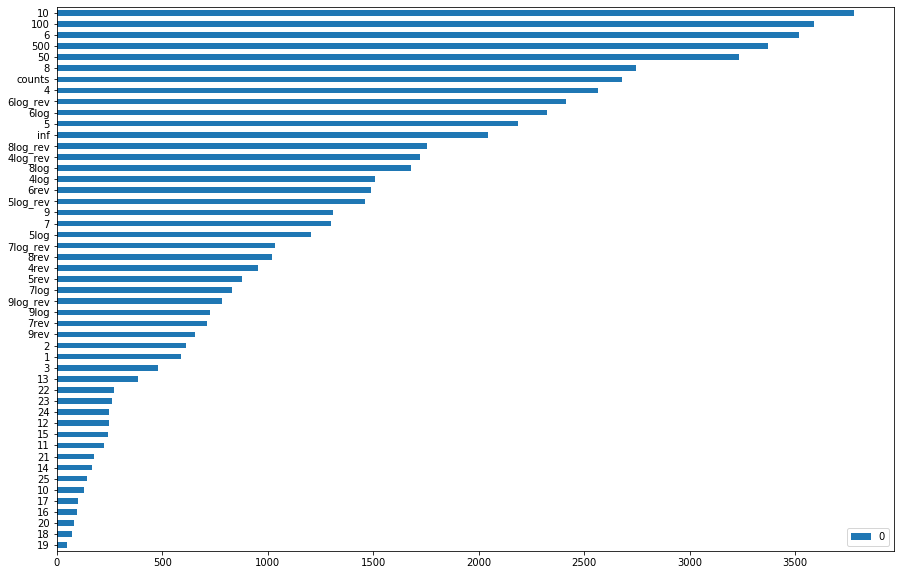

In [288]:

_.plot(kind='barh', figsize=(15,10))

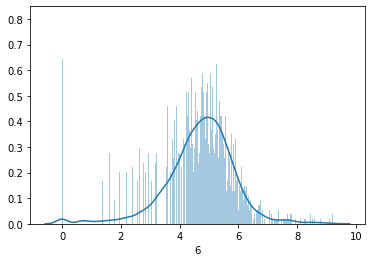

In [71]:
sns.distplot(np.log(X1['6']+1), bins=len(np.unique(X1['6'])))

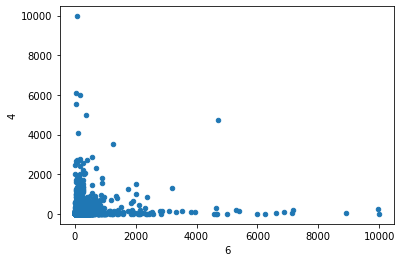

In [186]:
X1.merge(X2.groupby('id').count(), right_index = True, left_on='id').plot('6', '4', kind='scatter')

In [ ]:
cols = ['5','7', '4', '6', '8','9']

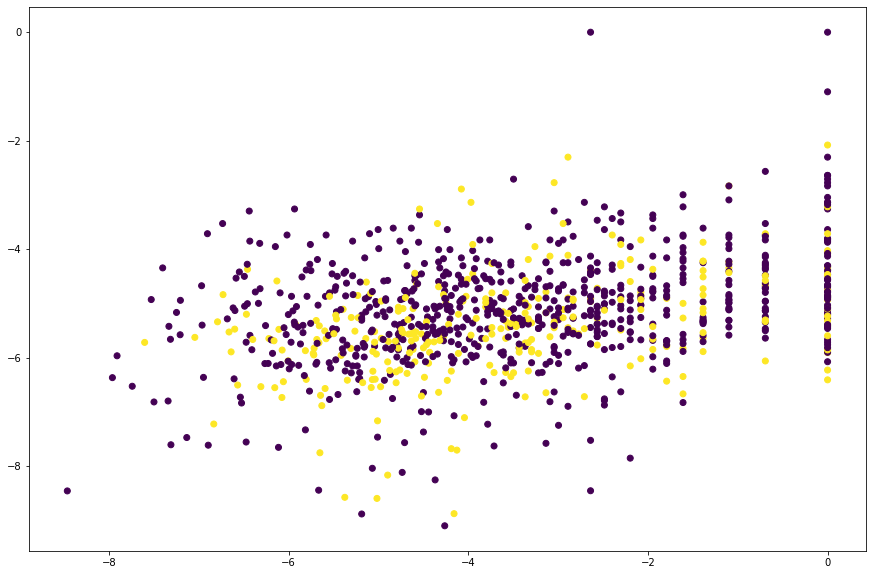

In [195]:
check = X1.merge(X2.groupby('id').count(), right_index = True, left_on='id')
plt.figure(figsize=(15,10))
plt.scatter(np.log((X1['4']+1)**-1)[:1000], np.log((X1['6']+1)**-1)[:1000], c=Y.iloc[:1000,1], alpha=1)

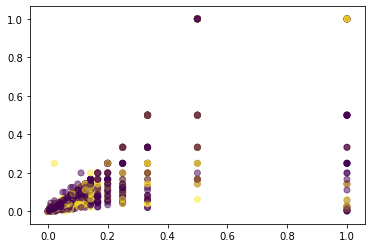

In [197]:
plt.scatter((check['8']+1.0)**-1, (check['A'].astype(float))**-1, c = Y.iloc[:,1], alpha=0.5)

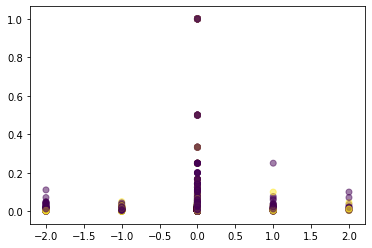

In [222]:
plt.scatter(check['2'], (check['6'].astype(float))**-1, c = Y.iloc[:,1], alpha=0.5)

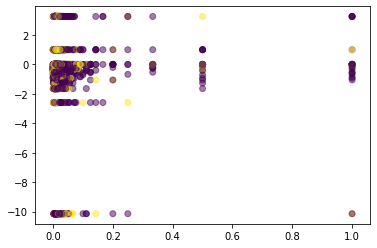

In [333]:
plt.scatter((((check['6']+1.0)**-1)).values,\
                ((np.log((check['4'].astype(float))**-1)+1)**-1)\
                 , c = Y.iloc[:,1], alpha=0.5)

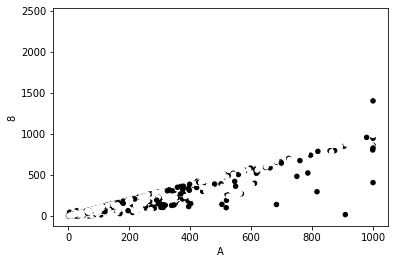

In [302]:
X1.merge(X2.groupby('id').count(), right_index = True, left_on='id').plot('A', '8', kind='scatter', c=Y.iloc[:,1])